In [7]:
# libraries and settings
import os
import c3d
import glob2
import math
import numpy as np
# from mayavi.mlab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML, Image

%matplotlib inline

rc('animation', html='html5')

In [8]:
# try to read c3d files
folder_name = 'files_motions_589'
cd3data_path = os.path.join('data', 'motion_data', folder_name)
all_files = glob2.glob(cd3data_path+'/**/*[0-9].c3d', recursive=True)

print("Loading files....")
for files in all_files: 
    print(files)

# read c3d file
file_id = 0
reader = c3d.Reader(open(all_files[file_id], 'rb'))

Loading files....
data\motion_data\files_motions_589\pour01.c3d
data\motion_data\files_motions_589\pour02.c3d
data\motion_data\files_motions_589\pour03.c3d
data\motion_data\files_motions_589\pour04.c3d
data\motion_data\files_motions_589\pour05.c3d
data\motion_data\files_motions_589\pour06.c3d


### See information about marker points [here](https://motion-database.humanoids.kit.edu/marker_set/)

In [9]:
# function to read points from file
def read_c3d(c3d_file, objs_id_end, rh_id_start, lh_id_start, verbose=False):
    """
    read a c3d file and output the groups in the scene with the path of the end point
    """
    # read file
    reader = c3d.Reader(open(c3d_file, 'rb'))
    
    # reader.point_used
    point_labels = reader.point_labels
    dis = 8 # distance of the endpoint id
    
    if verbose:
        print("\nRight arm points:")
        print(point_labels[rh_id_start:rh_id_start+10])

        print("\nLeft arm points:")
        print(point_labels[lh_id_start:lh_id_start+10])

        print("\nEnd point markers:")
        print(point_labels[rh_id_start+dis:rh_id_start+dis+2])
        print(point_labels[lh_id_start+dis:lh_id_start+dis+2])
    
    object_points_ids = list(range(objs_id_end))
    left_arm_points_ids = list(range(lh_id_start,lh_id_start+10)) #28
    right_arm_points_ids = list(range(rh_id_start,rh_id_start+10)) #38

    lh_traj_points_id = list(range(lh_id_start+dis,lh_id_start+dis+2))
    rh_traj_points_id = list(range(rh_id_start+dis,rh_id_start+dis+2))

    scene_groups_ids = [object_points_ids, left_arm_points_ids, right_arm_points_ids]
    traj_groups_ids = [lh_traj_points_id, rh_traj_points_id]
    
    # collect points of interest
    scene_groups = []
    for group in scene_groups_ids:
        group_points = []
        for point_id in group:
            point_marker = []
            for i, points, analog in reader.read_frames():
                point_marker.append(points[point_id][:3])
            group_points.append(point_marker)
        scene_groups.append(np.array(group_points))
        
    # for trajectory points that we want to trace
    traj_groups = []
    for group in traj_groups_ids:
        traj_points = []
        for point_id in group:
            point_marker = []
            for i, points, analog in reader.read_frames():
                traj_mrkrs = points[point_id][:3]
                point_marker.append(traj_mrkrs)
            traj_points.append(point_marker)
        traj_groups.append(np.array(traj_points))
    
    # we want to create path from the traj_points
    mid_points = []
    for group in traj_groups:
        point_a = group[0]
        point_b = group[1]
        mid_points.append((point_a + point_b)/2.0)

    
    
    return scene_groups, mid_points

In [10]:
# read c3d file
objs_id_end = 12
lh_id_start = 21
rh_id_start = 31
# dis = 8 # distance of the endpoint id

all_scene_groups = []
# all_mid_points = []
lh_paths = []
rh_paths = []
for files in all_files:
    scene_groups, mid_points = read_c3d(files, 
                                        objs_id_end, 
                                        rh_id_start, 
                                        lh_id_start,
                                        verbose=0)
    lh_paths.append(mid_points[0])
    rh_paths.append(mid_points[1])

important segments:

0 -- [190:333], [333:460]

(143, 3)


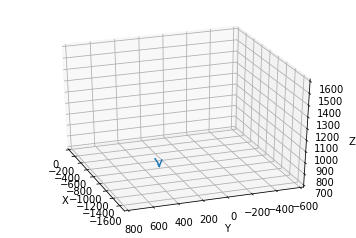

In [12]:
# extract a sample path
sample_id = 0
sample_line = rh_paths[sample_id][190:333]
sample_line2 = rh_paths[sample_id][333:450]
print(np.shape(sample_line))
x = sample_line[:,0]
y = sample_line[:,1]
z = sample_line[:,2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d([-1700.0, 0.0])
ax.set_xlabel('X')

ax.set_ylim3d([-600.0, 800.0])
ax.set_ylabel('Y')

ax.set_zlim3d([700.0, 1600.0])
ax.set_zlabel('Z')
ax.azim = 160 #200
ax.elev = 30
ax.plot(x, y, z)

In [43]:
# generic plot function
def plot_3d(data_list, ax=None):
    """
    data is a tuple of x, y, z
    """
    if ax==None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
#         ax.set_xlim3d([-1700.0, 0.0])
        ax.set_xlabel('X')

#         ax.set_ylim3d([-600.0, 800.0])
        ax.set_ylabel('Y')

#         ax.set_zlim3d([700.0, 1600.0])
        ax.set_zlabel('Z')
        ax.azim = 160 #200
        ax.elev = 30
    
    for data in data_list:
        x = data[:,0]
        y = data[:,1]
        z = data[:,2]
        ax.plot(x, y, z)

def plot_line(data, ln=None):
    if ln==None:
        fig = plt.figure()
        ln = fig.add_subplot(111)
    ln.plot(data)
    return ln

def plot_scatter(x, y, ln=None):
    if ln==None:
        fig = plt.figure()
        ln = fig.add_subplot(111)
    ln.scatter(x, y)
    return ln

In [44]:
def cubic_func(t, a, b, c, d):
    return a + b*t + c*t**2 + d*t**3 

def poly_func(t, params):
    y = params[0]
    for i in range(1, len(params)):
        y = y + (params[i]*t**i)
    return y

In [45]:
# try fit for x, y, and z
import scipy.optimize as optimize

t = np.arange(len(x))
guess = (1,1,1,1)

x = sample_line[:,0]
curve_params = []
new_curve = []
for axes in range(3):
    x = sample_line[:,axes]
    # params = np.polyfit(t,x,2)
    # new_x = np.poly1d(params)(t)
    params, pcov = optimize.curve_fit(cubic_func, x, t)
    new_x = cubic_func(t, *params)
    new_curve.append(new_x)

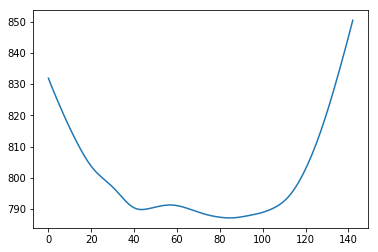

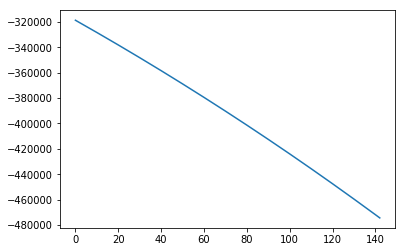

In [46]:
plot_line(x)
plot_line(new_curve[0])

In [47]:
params, pcov = optimize.curve_fit(cubic_func, x, t)

[ 15.60972135   1.00000727]


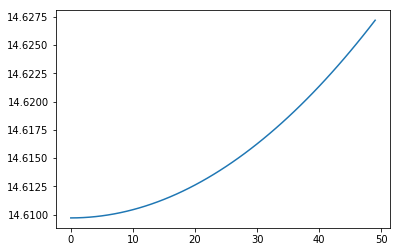

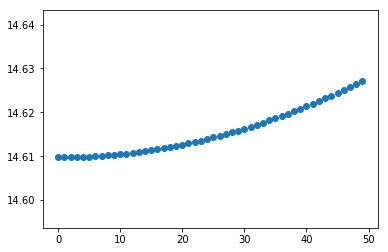

In [48]:
def quadratic(t, a, b):
    return a + b*t**2

time = np.arange(50)
y = quadratic(time, 100, 1)

params, pcov = optimize.curve_fit(quadratic, y, time)
# ln = plot_line(y)
plot_line(quadratic(time, *params))
plot_scatter(time, quadratic(time, *params))
print(params+1)

In [49]:
file_id = 0
scene_groups, mid_points = read_c3d(all_files[file_id], 
                                    objs_id_end, 
                                    rh_id_start, 
                                    lh_id_start,
                                    verbose=0)
# save mid_points data
l_mid_point = mid_points[0]
r_mid_point = mid_points[1]
total_steps = len(l_mid_point)

In [50]:
np.shape(sample_line)

(143, 3)

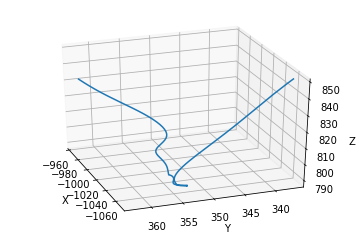

In [54]:
# analytical solution using the normal equation: (X^T*X)^-1*X^T*Y
def solve_poly(var, t, order=3):
    var_dim = np.shape(t)[0]
    T1 = np.ones_like(t)
    T2 = t
    T_array = [T1, T2]
    for i in range(2, order+1):
        T_array.append(T2**i)
    T=np.transpose(np.array(T_array))
    T_transpose = np.transpose(T)
    params = np.matmul(np.linalg.inv(np.matmul(T_transpose,T)), 
                       np.matmul(T_transpose, var))
    new_x = poly_func(t, params)
    
    return new_x

new_curve = []
for axes in range(3):
    var = sample_line[:,axes]
    new_x = solve_poly(var, t, 3)
    new_curve.append(new_x)

ax = plot_3d([sample_line, np.transpose(new_curve)])

In [52]:
np.shape(t)[0]

143

### Visualize arm motion and path of the end point

In [284]:
grp_nos = 3
def update_lines(num, dataLines, lines):
    for i,groups in enumerate(scene_groups[:grp_nos]):
        frame = groups[:,num,:]

        x_data = frame[:,0]
        y_data = frame[:,1]
        z_data = frame[:,2]
        graph_list[i]._offsets3d = (x_data, y_data, z_data)
        
    title.set_text('Wrist Path Trace, time step={}'.format(num))
        
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
# ax = p3.Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')


# the data
data = [np.transpose(r_mid_point)]

# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], linewidth=2)[0] for dat in data]

# plot initial data for scatter points
colours = ['r', 'b', 'g', 'k']
graph_list = []
for i, groups in enumerate(scene_groups[:grp_nos]):
    x_data = groups[:,0,:][:,0]
    y_data = groups[:,0,:][:,1]
    z_data = groups[:,0,:][:,2]
    graph = ax.scatter(x_data, y_data, z_data, c=colours[i])
    graph_list.append(graph)

title = ax.set_title('Wrist Path Trace')
# Setting the axes properties
ax.set_xlim3d([-1700.0, 0.0])
ax.set_xlabel('X')

ax.set_ylim3d([-600.0, 800.0])
ax.set_ylabel('Y')

ax.set_zlim3d([700.0, 1600.0])
ax.set_zlabel('Z')
ax.azim = 160 #200
ax.elev = 30

# Creating the Animation object
ani = animation.FuncAnimation(fig, update_lines, total_steps, fargs=(data, lines),
                                   interval=0, blit=False)

plt.show()



In [ ]:
# display image or animation through here:
# Image(url='data/media_outputs/basic_animation.gif')

In [ ]:
# from: https://cs231n.github.io/optimization-1/
def eval_numerical_gradient(f, x):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros(x.shape)
  h = 0.00001

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    old_value = x[ix]
    x[ix] = old_value + h # increment by h
    fxh = f(x) # evalute f(x + h)
    x[ix] = old_value # restore to previous value (very important!)

    # compute the partial derivative
    grad[ix] = (fxh - fx) / h # the slope
    it.iternext() # step to next dimension

  return grad